In [1]:
import pandas as pd
import numpy as np
import pickle
from StringContains import ContainedStringCase 
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import os
from scipy.stats import ks_2samp, ttest_rel, f, mannwhitneyu, pearsonr, spearmanr, kendalltau
from jmh_parser import parseFile
from benchmarkutils import get_data_frame_from_csv, get_ks_2sample_test_log, get_mann_whitney_u_test_test_log, read_log
from statsmodels.formula.api import ols
import statsmodels.api as sm
import glob
import math

In [2]:
output_dir = "http_singleStrings_ratio0.95/"
df = pd.read_csv(output_dir + "http_8192_0.95_9.csv")
files = glob.glob(output_dir + "*[0-9].csv", recursive=False)
print(len(files))
df

165


,Benchmark,Mode,Threads,Samples,Score,Score Error (99.9%),Unit,Param: regex,Param: str
0,benchmark.StringContains.regexMatches,avgt,1,100,3290.868141,61.062790,ns/op,http,.@vP3od\raA^e7ur7F8d9J\r~l{k\2Y_h!8{ krC76z57/...
1,benchmark.StringContains.stringContains,avgt,1,100,1141.760653,0.881907,ns/op,http,.@vP3od\raA^e7ur7F8d9J\r~l{k\2Y_h!8{ krC76z57/...


In [3]:
t = parseFile(output_dir + "http_8192_0.95_9.log")
print(t.columns,t.dtypes)
t = t[["Fork","Full Bench","Iteration", "Iteration Type", "Method", "Score"]]
t = t.loc[t["Iteration Type"]=="measured",:]
t = t.astype({"Score":"float"})
t

Index(['Benchmark Mode', 'Class', 'Fork', 'Full Bench', 'Full params',
       'Iteration', 'Iteration Type', 'Measurement Unit', 'Method', 'Package',
       'Score', 'Threads', 'Total Fork'],
      dtype='object') Benchmark Mode       object
Class                object
Fork                float64
Full Bench           object
Full params          object
Iteration            object
Iteration Type       object
Measurement Unit     object
Method               object
Package              object
Score                object
Threads              object
Total Fork           object
dtype: object


,Fork,Full Bench,Iteration,Iteration Type,Method,Score
5,1.0,benchmark.StringContains.regexMatches,1,measured,regexMatches,3301.530
6,1.0,benchmark.StringContains.regexMatches,2,measured,regexMatches,3300.315
7,1.0,benchmark.StringContains.regexMatches,3,measured,regexMatches,3301.931
8,1.0,benchmark.StringContains.regexMatches,4,measured,regexMatches,3297.609
9,1.0,benchmark.StringContains.regexMatches,5,measured,regexMatches,3301.504
...,...,...,...,...,...,...
245,5.0,benchmark.StringContains.stringContains,16,measured,stringContains,1137.233
246,5.0,benchmark.StringContains.stringContains,17,measured,stringContains,1138.722
247,5.0,benchmark.StringContains.stringContains,18,measured,stringContains,1141.226
248,5.0,benchmark.StringContains.stringContains,19,measured,stringContains,1140.427


In [4]:
t.loc[t["Method"] =="regexMatches","Score"].mean(), t.loc[t["Method"] =="regexMatches","Score"].std()

(3290.8681500000002, 180.0450266075366)

In [5]:
t.loc[t["Method"] !="regexMatches","Score"].mean(), t.loc[t["Method"] !="regexMatches","Score"].std()

(1141.76064, 2.600295595162632)

In [6]:
def get_data_frame_from_csv(output_dir: str):
    files = glob.glob(output_dir + "*[0-9].csv", recursive=False)
    data = []
    for file_name in files:
        *regex, input_len, match_pos_ratio, sample = file_name[:-4].split("_")
        df = pd.read_csv(file_name)
        df = df.loc[:, ["Benchmark", "Score", "Score Error (99.9%)"]]
        df['Benchmark'] = df["Benchmark"].map(lambda x: x.split(".")[-1])
        df['str_len'] = input_len
        df['sample'] = sample
        df['match_pos_ratio'] = match_pos_ratio
        df['Score_int'] = df['Score'].round().astype(int) ## Score from float to int
        df['matches'] = df["match_pos_ratio"] != '1'
        data.append(df)
        
    df = pd.concat(data, ignore_index=True)
#     df = df.pivot_table(values = ["Score", "Score_int", 'Score Error (99.9%)'], index=["str_len","match_pos_ratio", "sample", "Score_int"], columns="Benchmark")
#     return df
#     df.reset_index(drop=False, inplace=True) 
#     df['improve_ratio'] = df["regexMatches"] / df['stringContains']
    return df

In [7]:
df = get_data_frame_from_csv(output_dir)

In [8]:
df_float = df.astype({"str_len":"int", "sample":"int","match_pos_ratio":"float"})

In [9]:
df_float

,Benchmark,Score,Score Error (99.9%),str_len,sample,match_pos_ratio,Score_int,matches
0,regexMatches,25039.525231,22.727775,65536,8,0.95,25040,True
1,stringContains,9414.086870,2.718938,65536,8,0.95,9414,True
2,regexMatches,196.075981,5.044073,256,9,0.95,196,True
3,stringContains,43.827454,0.177389,256,9,0.95,44,True
4,regexMatches,316.172591,14.212466,512,11,0.95,316,True
...,...,...,...,...,...,...,...,...
325,stringContains,43.611641,0.140370,256,4,0.95,44,True
326,regexMatches,301.473122,16.483944,512,6,0.95,301,True
327,stringContains,77.561157,0.381154,512,6,0.95,78,True
328,regexMatches,24019.591083,659.264468,65536,5,0.95,24020,True


In [10]:
t = df_float.pivot_table(values = ["Score","Score Error (99.9%)","Score_int"], index=["str_len","sample", "match_pos_ratio"], columns="Benchmark")
t.reset_index(drop=False, inplace=True) 
t
#     df['substr'] = regex
#     df['data_index'] = "_".join(data_index)
#     df['improve_ratio'] = df["regexMatches"] / df['stringContains']

str_len sample match_pos_ratio         Score                 \
Benchmark                                 regexMatches stringContains   
0              64      0            0.95    133.895898      16.652807   
1              64      1            0.95    134.738489      16.764034   
2              64      2            0.95    131.320167      16.713029   
3              64      3            0.95    131.632958      16.733744   
4              64      4            0.95    127.943064      16.762781   
..            ...    ...             ...           ...            ...   
160         65536     10            0.95  25030.052782    9209.893869   
161         65536     11            0.95  24694.981060    9360.390398   
162         65536     12            0.95  24515.877006    9440.368231   
163         65536     13            0.95  24592.867824    9345.790733   
164         65536     14            0.95  24774.157721    9357.689727   

          Score Error (99.9%)                   Score_int                 
Benchmark        regexMatches stringContains regexMatches stringContains  
0                    2.528224       0.053192          134             17  
1                    2.750979       0.115635          135             17  
2                    2.523819       0.106549          131             17  
3                    2.411546       0.106570          132             17  
4                    2.028205       0.105478          128             17  
..                        ...            ...          ...            ...  
160                 23.739809       6.297960        25030           9210  
161                166.202881       8.369875        24695           9360  
162                203.074559      20.763970        24516           9440  
163                207.271410       5.482913        24593           9346  
164                172.024584       8.849176        24774           9358  

[165 rows x 9 columns]

In [11]:
t["improve_ratio"] = t["Score"]["regexMatches"] / t["Score"]["stringContains"]

In [12]:
type(t["Score"]["regexMatches"])

pandas.core.series.Series

In [13]:
t["str_len_log2"] = t['str_len'].apply(lambda x: math.log2(x))

In [14]:
t

str_len sample match_pos_ratio         Score                 \
Benchmark                                 regexMatches stringContains   
0              64      0            0.95    133.895898      16.652807   
1              64      1            0.95    134.738489      16.764034   
2              64      2            0.95    131.320167      16.713029   
3              64      3            0.95    131.632958      16.733744   
4              64      4            0.95    127.943064      16.762781   
..            ...    ...             ...           ...            ...   
160         65536     10            0.95  25030.052782    9209.893869   
161         65536     11            0.95  24694.981060    9360.390398   
162         65536     12            0.95  24515.877006    9440.368231   
163         65536     13            0.95  24592.867824    9345.790733   
164         65536     14            0.95  24774.157721    9357.689727   

          Score Error (99.9%)                   Score_int                 \
Benchmark        regexMatches stringContains regexMatches stringContains   
0                    2.528224       0.053192          134             17   
1                    2.750979       0.115635          135             17   
2                    2.523819       0.106549          131             17   
3                    2.411546       0.106570          132             17   
4                    2.028205       0.105478          128             17   
..                        ...            ...          ...            ...   
160                 23.739809       6.297960        25030           9210   
161                166.202881       8.369875        24695           9360   
162                203.074559      20.763970        24516           9440   
163                207.271410       5.482913        24593           9346   
164                172.024584       8.849176        24774           9358   

          improve_ratio str_len_log2  
Benchmark                             
0              8.040440          6.0  
1              8.037355          6.0  
2              7.857353          6.0  
3              7.866318          6.0  
4              7.632568          6.0  
..                  ...          ...  
160            2.717735         16.0  
161            2.638243         16.0  
162            2.596920         16.0  
163            2.631438         16.0  
164            2.647465         16.0  

[165 rows x 11 columns]

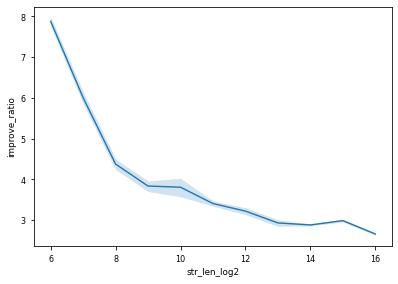

In [15]:
sns.lineplot(data=t, x="str_len_log2", y="improve_ratio")

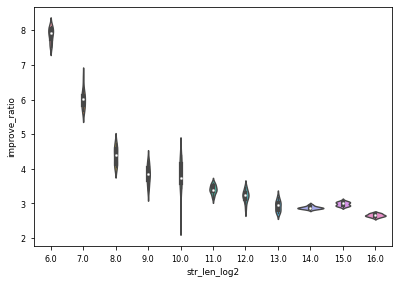

In [17]:
sns.violinplot(data=t, x="str_len_log2", y="improve_ratio")

In [24]:
t.loc[:,["str_len","improve_ratio"]]

,str_len,improve_ratio
Benchmark,,
0,64,8.040440
1,64,8.037355
2,64,7.857353
3,64,7.866318
4,64,7.632568
...,...,...
160,65536,2.717735
161,65536,2.638243
162,65536,2.596920


In [26]:
t["str_len"].value_counts()

1024     15
128      15
512      15
64       15
65536    15
32768    15
16384    15
8192     15
4096     15
2048     15
256      15
Name: str_len, dtype: int64